# Word embedding : Gensim Doc2Vec

In this notebook, we will use the [Gensim Doc2Vec model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html) to compute Word Embedding on our tweets dataset, before training a classification model on the lower-dimension vector space.

We will compare this pre-trained cloud model to the baseline model from [main.ipynb](main.ipynb).


## Load project modules and data

We will use basic python packages, and the [`Gensim`](https://radimrehurek.com/gensim/intro.html) package to use the Doc2Vec model.

In [1]:
import pickle
from tqdm import tqdm
import datetime

# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import data.helpers as data_helpers
import visualization.helpers as viz_helpers

# Maths modules
import pandas as pd
import tensorflow as tf

# Viz modules
import plotly.express as px

# Render for export
import plotly.io as pio

pio.renderers.default = "notebook"


In [2]:
# Download and unzip CSV files
!cd .. && make dataset && cd notebooks

>>> Downloading and extracting data files...
Data files already downloaded.
>>> OK.



In [3]:
# Load data from CSV
df = pd.read_csv(
    os.path.join(
        "..", "data", "raw", "training.1600000.processed.noemoticon.csv"
    ),
    names=["target", "id", "date", "flag", "user", "text"],
)

# Reduce memory usage
df = data_helpers.reduce_dataframe_memory_usage(df)

# Drop useless columns
df.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
df.target.replace(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    },
    inplace=True,
)

df.describe()


,target,text
count,1600000,1600000
unique,2,1581466
top,NEGATIVE,isPlayer Has Died! Sorry
freq,800000,210


## Text pre-processing



In [4]:
from sklearn.model_selection import train_test_split

df.target.replace(
    {
        "NEGATIVE": 0,
        "POSITIVE": 1,
    },
    inplace=True,
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df.text,
    df.target,
    test_size=0.2,
    stratify=df.target,
    random_state=42,
)


## Basic FFNN (Feed Forward Neural Network) model 



### FFNN on simple word count vectors


In [23]:
from keras.models import load_model, save_model
from keras.models import Sequential
from keras.layers import Input, TextVectorization, Dense, Dropout, Activation
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC


model_name="ffnn_on_count"
vocabulary_size = 10000

results_data_path = os.path.join("..", "results")
model_file_path = os.path.join(results_data_path, model_name)

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="count",
        max_tokens=vocabulary_size,
        pad_to_max_tokens=True,
    )
    vectorize_layer.adapt(
        df.text,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Dense(100, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

    model.save(model_file_path)


print(model.summary())


Model: "ffnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 10000)            0         
 ectorization)                                                   
                                                                 
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,001,121
Trainable params: 1,001,121
Non-trainable params: 0
____________________________________________________

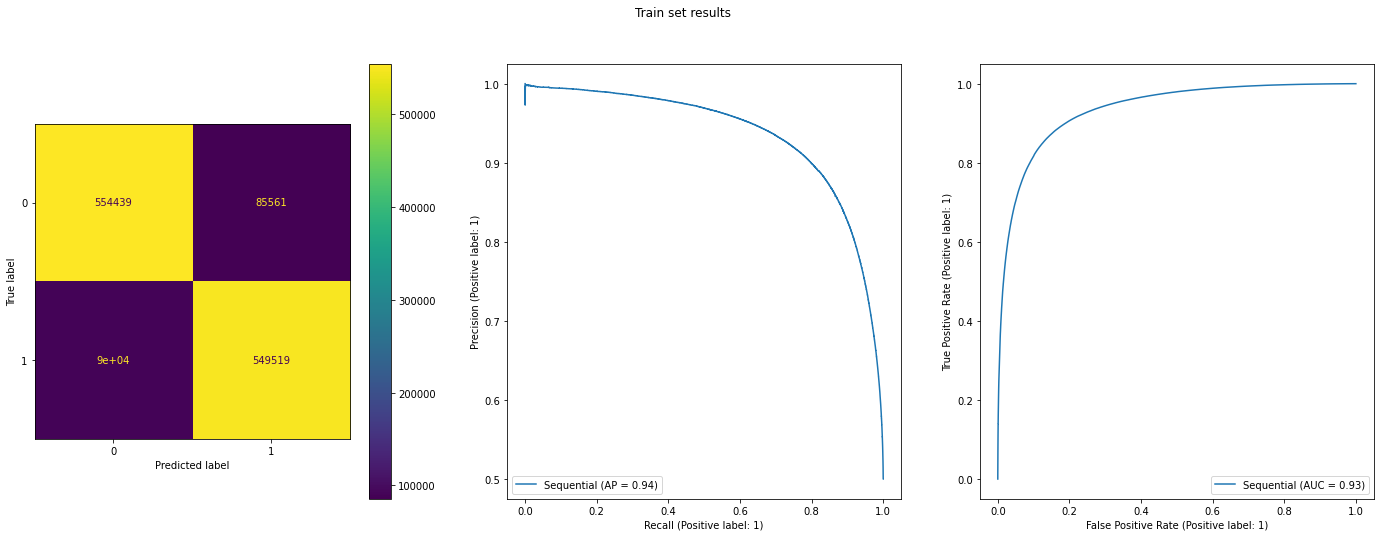

In [25]:
y_train_pred_proba = model.predict(
    X_train,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_train_pred = [round(pred_proba[0]) for pred_proba in y_train_pred_proba]

viz_helpers.plot_classifier_results(
    model,
    X_train,
    y_train,
    y_train_pred,
    y_train_pred_proba,
    title="Train set results",
)


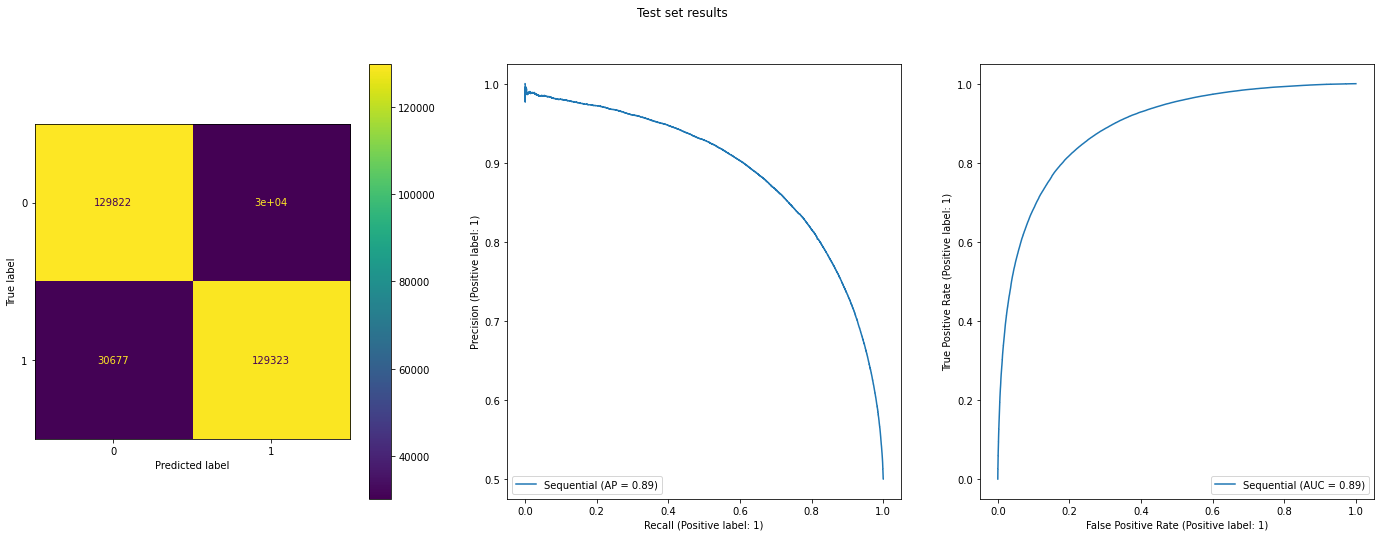

In [26]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

viz_helpers.plot_classifier_results(
    model,
    X_test,
    y_test,
    y_test_pred,
    y_test_pred_proba,
    title="Test set results",
)


### FFNN on word count vectors after SpaCy lemmatization


In [38]:
# Tokenizers, Stemmers and Lemmatizers
import spacy

# Download SpaCy model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Define tokenizer
tokenizer = lambda text: [  # SpaCy Lemmatizer
    token.lemma_.lower()
    for token in nlp(text)
    if token.is_alpha and not token.is_stop
]

# Processed data path
processed_data_path = os.path.join("..", "data", "processed")
tokenized_dataset_file_path = os.path.join(processed_data_path, "spacy_dataset.pkl")

if os.path.exists(tokenized_dataset_file_path):
    # Load tokenized dataset
    with (open(tokenized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
else:
    # Tokenize dataset
    X = df.text.apply(tokenizer)

    # Save tokenized dataset as pickle
    with open(tokenized_dataset_file_path, "wb") as f:
        pickle.dump(X, f)


2022-01-14 12:34:27.146558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 12:34:27.146588: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 189 kB/s             
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [39]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec


# Processed data path
processed_data_path = os.path.join("..", "data", "processed")
vectorized_dataset_file_path = os.path.join(processed_data_path, "doc2vec_spacy_dataset.pkl")

if os.path.exists(vectorized_dataset_file_path):
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
else:
    # Tag documents for training
    X = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]

    # Train doc2vec model
    doc2vec = Doc2Vec()
    doc2vec.build_vocab(X)
    doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

    # Vectorize text
    X = [doc2vec.infer_vector(doc.words) for doc in X]

    # Save vectorized dataset as pickle
    with open(vectorized_dataset_file_path, "wb") as f:
        pickle.dump(X, f)


In [40]:
from sklearn.model_selection import train_test_split


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    df.target,
    test_size=0.2,
    stratify=df.target,
    random_state=42,
)


In [55]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Input,
    TextVectorization,
    Dense,
    Dropout,
    Activation,
    Embedding,
)
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC


model_name = "ffnn_on_doc2vec"
vector_size = len(X[0])

results_data_path = os.path.join("..", "results")
model_file_path = os.path.join(results_data_path, model_name)

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # define NN model
    model = Sequential(name=model_name)
    model.add(Dense(100, input_shape=(vector_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

    # fit NN model
    model.fit(
        np.stack(X_train, axis=0),
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

    model.save(model_file_path)


print(model.summary())


Epoch 1/10
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5661 - accuracy: 0.7049 - ROC_AUC: 0.7767 - AP: 0.7634 - val_loss: 0.5501 - val_accuracy: 0.7170 - val_ROC_AUC: 0.7920 - val_AP: 0.7809
Epoch 2/10
8000/8000 [==============================] - 19s 2ms/step - loss: 0.5506 - accuracy: 0.7158 - ROC_AUC: 0.7914 - AP: 0.7797 - val_loss: 0.5485 - val_accuracy: 0.7146 - val_ROC_AUC: 0.7969 - val_AP: 0.7863
Epoch 3/10
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5459 - accuracy: 0.7196 - ROC_AUC: 0.7957 - AP: 0.7847 - val_loss: 0.5395 - val_accuracy: 0.7248 - val_ROC_AUC: 0.8022 - val_AP: 0.7924
Epoch 4/10
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5433 - accuracy: 0.7212 - ROC_AUC: 0.7980 - AP: 0.7873 - val_loss: 0.5384 - val_accuracy: 0.7245 - val_ROC_AUC: 0.8031 - val_AP: 0.7937
Epoch 5/10
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5417 - accuracy: 0.7223 - ROC_AUC: 0.7995 - AP: 0.7890 - val_

In [58]:
y_train_pred_proba = model.predict(
    np.stack(X_train, axis=0),
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
    verbose=1,
)


10000/10000 [==============================] - 7s 652us/step


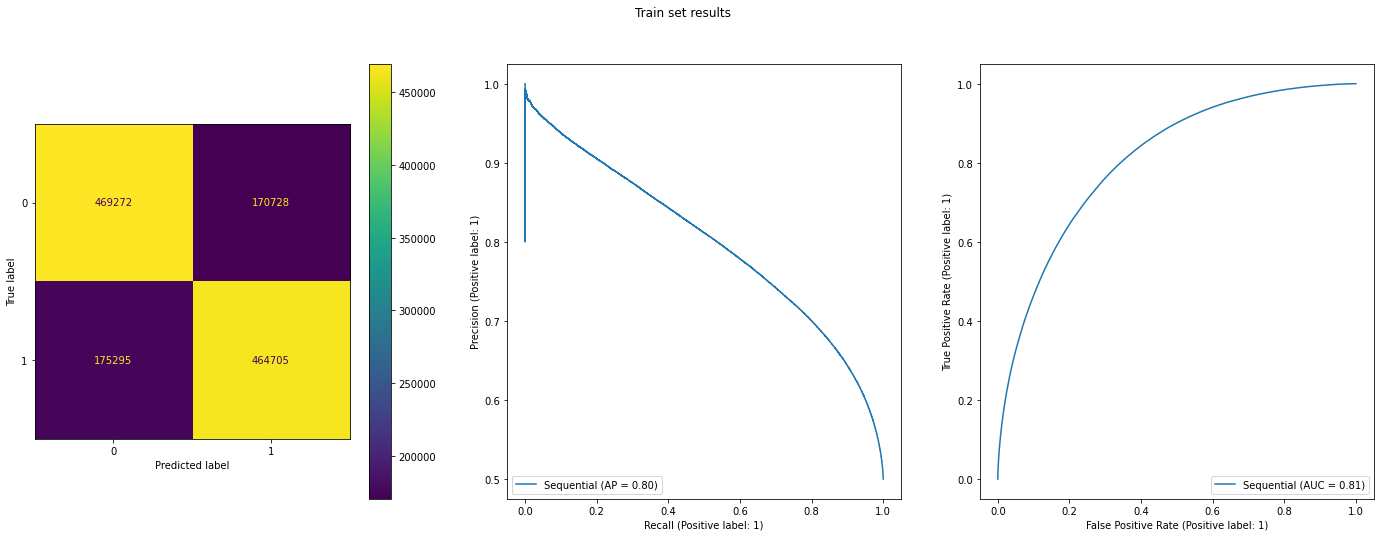

In [59]:
y_train_pred = [round(pred_proba[0]) for pred_proba in y_train_pred_proba]

viz_helpers.plot_classifier_results(
    model,
    X_train,
    y_train,
    y_train_pred,
    y_train_pred_proba,
    title="Train set results",
)


In [61]:
y_test_pred_proba = model.predict(
    np.stack(X_test, axis=0),
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)


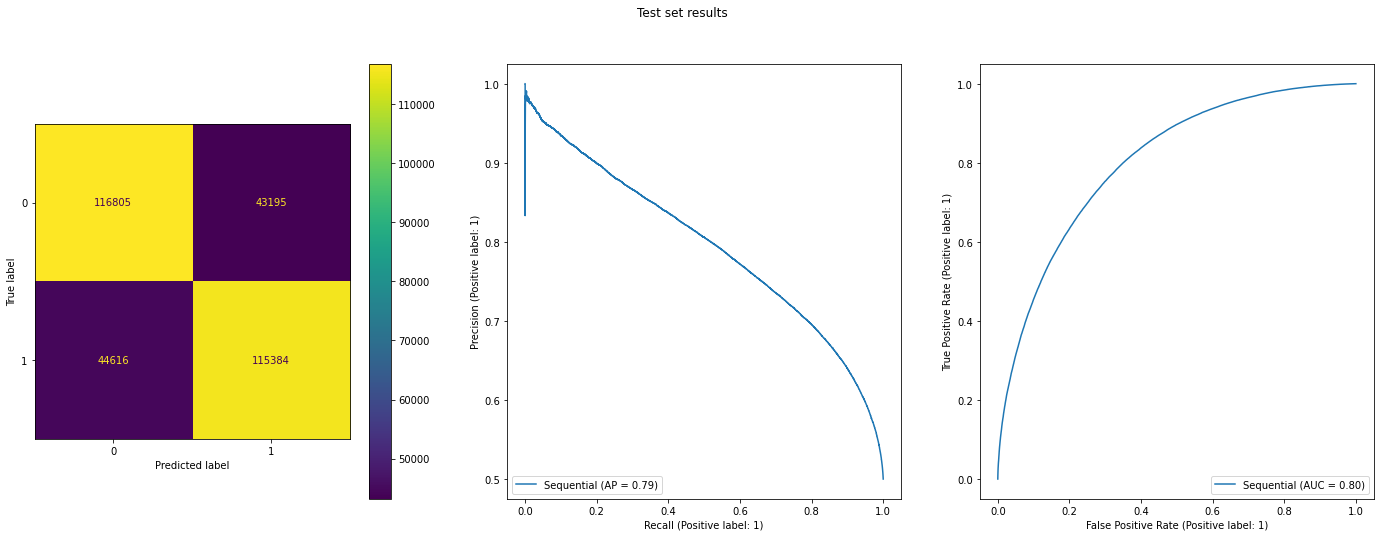

In [62]:
y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

viz_helpers.plot_classifier_results(
    model,
    X_test,
    y_test,
    y_test_pred,
    y_test_pred_proba,
    title="Test set results",
)


## NN model with LSTM (Long Short Term Memory) layer



## BERT (Bidirectional Encoder Representations from Transformers) model

